In [ ]:
!pip3 install yfinance

In [ ]:
!pip install PyPortfolioOpt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

junk = 0

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
import sklearn.model_selection

In [ ]:
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error


##ARIMA MODEL

In [ ]:
# Load the data
data = pd.read_csv('/content/drive/MyDrive/ML2_Data/international-airline-passengers.csv', engine='python', skipfooter=3)
# A bit of pre-processing to make it nicer
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m-%d')
data.set_index(['Month'], inplace=True)

# Plot the data
data.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

In [ ]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
train_data = data['1949-01-01':'1959-12-01']
test_data = data['1960-01-01':'1960-12-01']

In [ ]:
test_data

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [ ]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))


The smallest AIC is 618.2055123802811 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [ ]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

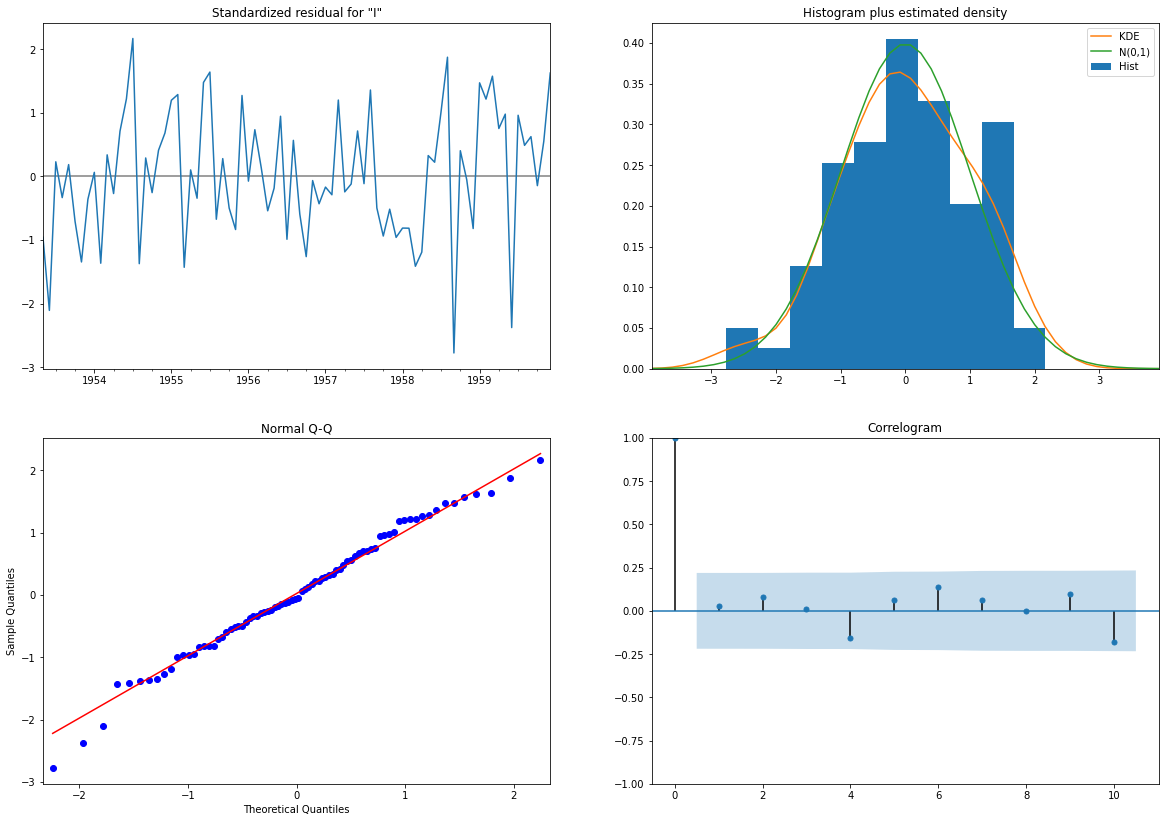

In [ ]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [ ]:
pred0 = results.get_prediction(start='1958-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [ ]:
pred1 = results.get_prediction(start='1958-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [ ]:
pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['1960-01-01':'1960-12-01'])

1960-01-01    419.493428
1960-02-01    397.830620
1960-03-01    460.855650
1960-04-01    449.447594
1960-05-01    474.552227
1960-06-01    537.848520
1960-07-01    614.885238
1960-08-01    628.210684
1960-09-01    519.333453
1960-10-01    462.251363
1960-11-01    412.159368
1960-12-01    452.659251
Freq: MS, Name: predicted_mean, dtype: float64


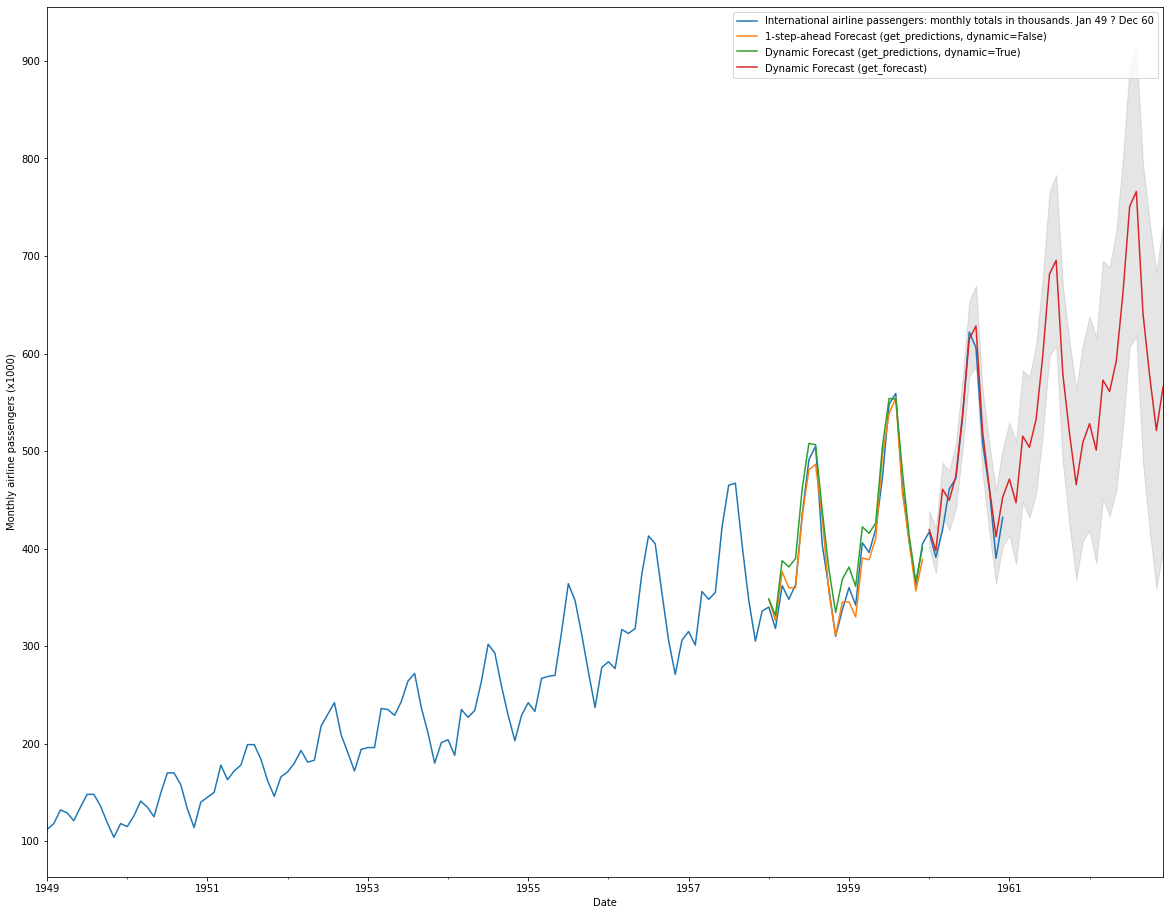

In [ ]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
prediction = pred2.predicted_mean['1960-01-01':'1960-12-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 1960 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of year 1960 is 2.81%


##our work

In [ ]:
import pandas as pd
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [ ]:
df = df[df["Date added"] <= "2010"]
print(df.shape)

(289, 8)


In [ ]:
df2 = df.groupby('GICS Sector', as_index=False).nth([0,1,2,3,4])
df2

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
6,ADM,ADM,Consumer Staples,Agricultural Products,"Chicago, Illinois",1957-03-04,7084,1902
7,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
8,ADP,ADP,Information Technology,Data Processing & Outsourced Services,"Roseland, New Jersey",1981-03-31,8670,1949
10,AES,AES Corporation,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",1998-10-02,874761,1981
11,AFL,Aflac,Financials,Life & Health Insurance,"Columbus, Georgia",1999-05-28,4977,1955
12,A,Agilent Technologies,Health Care,Health Care Equipment,"Santa Clara, California",2000-06-05,1090872,1999
13,APD,Air Products and Chemicals,Materials,Industrial Gases,"Allentown, Pennsylvania",1985-04-30,2969,1940
14,AKAM,Akamai,Information Technology,Internet Services & Infrastructure,"Cambridge, Massachusetts",2007-07-12,1086222,1998


In [ ]:
import yfinance as yf
import numpy as np

np.array(df2['Symbol'])

array(['MMM', 'ABT', 'ADM', 'ADBE', 'ADP', 'AES', 'AFL', 'A', 'APD',
       'AKAM', 'ALL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AEP', 'AXP', 'AIG',
       'AMT', 'AMP', 'ABC', 'AMGN', 'APH', 'ADI', 'APA', 'T', 'AZO',
       'AVB', 'AVY', 'BALL', 'BBWI', 'BAX', 'BBY', 'BA', 'BKNG', 'BXP',
       'BF.B', 'CHRW', 'CPB', 'CAT', 'CBRE', 'CNP', 'CF', 'CVX', 'CTAS',
       'CLX', 'CMS', 'CMCSA', 'COP', 'CTRA', 'DVN', 'DIS', 'EMN', 'EA',
       'EQR'], dtype=object)

In [ ]:
l = list(df2['Symbol'])
l.remove("BF.B")
data = yf.download(l, start="2010-01-01", end="2019-12-31", interval="1d")

[*********************100%***********************]  54 of 54 completed


In [ ]:
data

Adj Close                                                \
                    A        ABC        ABT        ADBE         ADI   
Date                                                                  
2010-01-04  20.301365  21.831715  19.433031   37.090000   22.960770   
2010-01-05  20.080835  21.675957  19.276022   37.700001   22.924517   
2010-01-06  20.009487  21.471003  19.383076   37.619999   22.881016   
2010-01-07  19.983538  21.126675  19.543655   36.889999   22.699764   
2010-01-08  19.977062  21.356228  19.643562   36.689999   22.830265   
...               ...        ...        ...         ...         ...   
2019-12-23  83.392944  81.556786  82.912262  328.950012  112.191643   
2019-12-24  83.432083  81.385277  82.845795  329.640015  112.709427   
2019-12-26  83.578812  81.032768  82.845795  331.200012  112.718842   
2019-12-27  83.549469  80.899353  82.959717  330.790009  112.455231   
2019-12-30  83.216202  79.689354  82.390198  328.339996  111.899788   

                                                                    ...  \
                  ADM         ADP        AEE        AEP        AES  ...   
Date                                                                ...   
2010-01-04  22.393158   27.491219  17.031658  20.947987  10.011559  ...   
2010-01-05  22.514118   27.343592  16.964169  20.708162   9.909028  ...   
2010-01-06  22.457191   27.279398  16.847597  20.918001   9.806496  ...   
2010-01-07  22.222378   27.266565  16.688080  21.097858   9.813818  ...   
2010-01-08  21.944868   27.228041  16.571501  21.349670  10.092122  ...   
...               ...         ...        ...        ...        ...  ...   
2019-12-23  42.419659  159.845978  69.960236  83.950584  18.075539  ...   
2019-12-24  42.474972  159.742584  70.061974  84.031174  18.020817  ...   
2019-12-26  42.585571  160.156235  69.960236  84.066994  18.175856  ...   
2019-12-27  42.677750  160.551102  70.570686  84.344597  18.221455  ...   
2019-12-30  42.511837  159.441696  70.811157  84.201317  18.276171  ...   

              Volume                                                           \
                 CVX       DIS      DVN       EA      EMN      EQR       GOOG   
Date                                                                            
2010-01-04  10173800  13700400  4225500  3850500  1446400  3299500   78541293   
2010-01-05  10593700  10307700  3711400  6632500  2269800  4545400  120638494   
2010-01-06  11014600  10709500  3225500  5047300  3099000  3409700  159744526   
2010-01-07   9626900   8202100  2836400  5433200  1076200  3637300  257533695   
2010-01-08   5624300   7657500  2496200  4055600   853400  2325900  189680313   
...              ...       ...      ...      ...      ...      ...        ...   
2019-12-23   5875000   9314000  6292100  1622600   509900  1087000   17662000   
2019-12-24   1640100   3508500  2780000   606100   162500   409400    6950000   
2019-12-26   3648600   4422000  3175300  1676500   282400   833900   13350000   
2019-12-27   4138300   5495300  3950700  1163400   646400  1008400   20768000   
2019-12-30   4580200   6602800  3549700  1758400   556800  1166000   21018000   

                                         
                MMM        MO         T  
Date                                     
2010-01-04  3043700  11048600  38576858  
2010-01-05  2847000  11742100  46650478  
2010-01-06  5268500  21307300  50172450  
2010-01-07  4470100  14983300  44486797  
2010-01-08  3405800  10822200  36586622  
...             ...       ...       ...  
2019-12-23  4876300   8046000  38581095  
2019-12-24  1259500   3684500  11515093  
2019-12-26  1435200   7351000  26239032  
2019-12-27  1472900   7700500  20430247  
2019-12-30  1715100   6691000  23389652  

[2515 rows x 324 columns]

In [ ]:
data = data['Adj Close']

data = data.pct_change()
data = data.dropna()
#data = np.log(1+data)
#data = data.dropna()

In [ ]:
data

,A,ABC,ABT,ADBE,ADI,ADM,ADP,AEE,AEP,AES,...,CVX,DIS,DVN,EA,EMN,EQR,GOOG,MMM,MO,T
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.010863,-0.007134,-0.008079,0.016446,-0.001579,0.005402,-0.005370,-0.003963,-0.011449,-0.010241,...,0.007084,-0.002495,0.001045,0.028099,-0.012794,-0.003892,-0.004404,-0.006263,0.000505,-0.004899
2010-01-06,-0.003553,-0.009455,0.005554,-0.002122,-0.001898,-0.002528,-0.002348,-0.006872,0.010133,-0.010347,...,0.000125,-0.005314,-0.003001,-0.025723,-0.006726,0.005711,-0.025209,0.014181,0.014646,-0.009823
2010-01-07,-0.001297,-0.016037,0.008285,-0.019405,-0.007921,-0.010456,-0.000470,-0.009468,0.008598,0.000747,...,-0.003767,0.000314,-0.005888,-0.007701,0.002477,0.009563,-0.023280,0.000718,-0.001493,-0.011228
2010-01-08,-0.000324,0.010866,0.005112,-0.005422,0.005749,-0.012488,-0.001413,-0.006986,0.011935,0.028358,...,0.001764,0.001571,0.001975,0.019955,0.002636,-0.012729,0.013331,0.007046,0.002492,-0.007326
2010-01-11,0.000649,0.011132,0.005087,-0.013083,-0.005716,0.000648,0.004479,0.008146,0.010391,0.006531,...,0.017743,-0.016311,-0.013663,-0.007065,0.000493,-0.002998,-0.001512,-0.004032,0.007459,-0.004797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.000821,-0.000817,0.007962,0.004090,-0.005425,0.005023,-0.006254,-0.012146,-0.012118,0.000505,...,0.005431,-0.014978,0.029839,-0.001482,0.004455,-0.007348,-0.000556,0.017677,0.008214,-0.002043
2019-12-24,0.000469,-0.002103,-0.000802,0.002098,0.004615,0.001304,-0.000647,0.001454,0.000960,-0.003027,...,0.000083,0.004216,0.011819,0.007051,0.001267,0.008406,-0.003914,-0.010030,-0.008480,-0.002816
2019-12-26,0.001759,-0.004331,0.000000,0.004732,0.000084,0.002604,0.002589,-0.001452,0.000426,0.008603,...,0.002161,0.002822,-0.006782,-0.000369,-0.002025,0.002612,0.012534,-0.000509,0.002387,0.005134


In [ ]:
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
      break
 
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  
  return np.array(X), np.array(y)

In [ ]:
n_steps = 60

dicti = {}

for c in data.columns:
  X_temp, y_temp = split_sequence(list(data[c]), n_steps)
  m, n = X_temp.shape

  train_len = 0
  dev_len = int(4*m/9) + train_len
  test_len = int(m/9) + dev_len
  X_train = X_temp[:dev_len]
  X_dev = X_temp[dev_len: test_len]
  X_test = X_temp[test_len: ]

  y_train = y_temp[:dev_len]
  y_dev = y_temp[dev_len: test_len]
  y_test = y_temp[test_len: ]

  dicti[c] = (X_train, y_train, X_dev, y_dev, X_test, y_test)
  #print(c)

#X_test, y_test = split_sequence(list(test_data[test_data.columns[1]]), n_steps)

In [ ]:
X_train_combined = []
X_dev_combined = []
X_test_combined = []

y_train_combined = []
y_dev_combined = []
y_test_combined = []

for c in data.columns:
  x1, y1, x2, y2, x3, y3 = dicti[c]
  X_train_combined.append(x1)
  y_train_combined.append(y1)

  X_dev_combined.append(x2)
  y_dev_combined.append(y2)

  X_test_combined.append(x3)
  y_test_combined.append(y3)

X_train_combined = np.array(X_train_combined)
X_dev_combined = np.array(X_dev_combined)
X_test_combined = np.array(X_test_combined)

y_train_combined = np.array(y_train_combined)
y_dev_combined = np.array(y_dev_combined)
y_test_combined = np.array(y_test_combined)


In [ ]:
X_tr = (X_train_combined.transpose(2,0,1).reshape(60,-1)).transpose()
X_tst = (X_test_combined.transpose(2,0,1).reshape(60,-1)).transpose()
X_dv = (X_dev_combined.transpose(2,0,1).reshape(60,-1)).transpose()

y_tr = y_train_combined.reshape(-1)
y_tst =  y_test_combined.reshape(-1)
y_dv =  y_dev_combined.reshape(-1)


In [ ]:
y_tst.shape

(58968,)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
l = len(data)
l1 = int(5*l/9)

In [ ]:
y_hat = {}
for c in data.columns:
  series = data[data.columns[1]].iloc[:l1]
  model = ARIMA(series, order=(5,1,0))
  model_fit = model.fit()
  forecast_test = model_fit.forecast(l - l1)
  y_hat[c] = forecast_test



In [ ]:
#print(model_fit.summary())

In [ ]:

for c in data.columns:
  m = mean_squared_error(data[c][l1:], y_hat[c].values)
  print(c, "mse = ", m)

A mse =  0.00024701131483547274
ABC mse =  0.00033894519901058655
ABT mse =  0.0002078929545188433
ADBE mse =  0.00031254501439952726
ADI mse =  0.00031238223661547867
ADM mse =  0.00023948348717814008
ADP mse =  0.00018507930097313242
AEE mse =  0.0001369137823234129
AEP mse =  0.00012914589104685755
AES mse =  0.00028667145361810316
AFL mse =  0.00014187802338286188
AIG mse =  0.00022784855807584888
AKAM mse =  0.00047517034865613133
ALL mse =  0.00015395137636579857
AMGN mse =  0.0002478753044441515
AMP mse =  0.0003301988625476414
AMT mse =  0.00017365104628149647
AMZN mse =  0.0003492531092179366
APA mse =  0.0007960329047569975
APD mse =  0.00017004440411732576
APH mse =  0.00017448155612434608
AVB mse =  0.00014735700005042156
AVY mse =  0.00021286486658105683
AXP mse =  0.00020014867292364412
AZO mse =  0.0002502773426595367
BA mse =  0.0002925243400001397
BALL mse =  0.0002179658049087238
BAX mse =  0.0001914634689909068
BBWI mse =  0.0006912458751295027
BBY mse =  0.000521200

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

In [ ]:
# de-annualize yearly interest rates
def deannualize(annual_rate, periods=365):
    return (1 + annual_rate) ** (1/periods) - 1

def get_risk_free_rate():
    # download 3-month us treasury bills rates
    annualized = yf.download("^IRX", start="2010-01-01", end="2019-12-31")["Adj Close"]
    
    # de-annualiz
    daily = annualized.apply(deannualize)

    # create dataframe
    return pd.DataFrame({"annualized": annualized, "daily": daily}) 

rates = get_risk_free_rate()/100
rates

[*********************100%***********************]  1 of 1 completed


,annualized,daily
Date,,
2010-01-04,0.00055,0.000001
2010-01-05,0.00060,0.000002
2010-01-06,0.00045,0.000001
2010-01-07,0.00045,0.000001
2010-01-08,0.00040,0.000001
...,...,...
2019-12-23,0.01520,0.000025
2019-12-24,0.01538,0.000026
2019-12-26,0.01535,0.000026


In [ ]:
def returns(actual_returns, weights):
    return np.dot(actual_returns.T, weights)

In [ ]:
def portfolio_optimize(predicted_returns, variances, risk_free):
    ef = EfficientFrontier(predicted_returns, variances, weight_bounds = (0,1))
    weights = ef.max_sharpe(risk_free_rate = risk_free)  
    
    tangencyweights = []
    for i in weights.values():
        tangencyweights.append(float(i))
    
    tangencyweights = np.array(tangencyweights)
    return tangencyweights

In [ ]:
def wrapper(input_features, predicted_returns, actual_returns, risk_free):
    variances = np.cov(input_features)
    weights = portfolio_optimize(predicted_returns, variances, risk_free)  
    return returns(actual_returns, weights)

In [ ]:
n = len(y_hat['A'])
predicted_returns_from_arima = np.zeros((n, 1))
for c in data.columns:
  predicted_returns_from_arima = np.append(predicted_returns_from_arima, y_hat[c].values.reshape(n, 1), axis=1)

predicted_returns_from_arima = np.delete(predicted_returns_from_arima, 0, 1)

In [ ]:
n = len(y_hat['A'])
actual_returns_from_arima = np.zeros((n, 1))
for c in data.columns:
  actual_returns_from_arima = np.append(actual_returns_from_arima, data[c][l1:].values.reshape(n, 1), axis=1)

actual_returns_from_arima = np.delete(actual_returns_from_arima, 0, 1)

In [ ]:
actual_returns_from_arima.shape

(1118, 54)

In [ ]:
predicted_returns_from_arima.shape

(1118, 54)

In [ ]:
results = np.zeros(predicted_returns_from_arima.shape[0])

for i in range(predicted_returns_from_arima.shape[1]):
  input_features = X_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], X_test_combined.shape[2])
  predicted_returns = predicted_returns_from_arima[i]
  #actual_returns = y_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1)
  actual_returns = actual_returns_from_arima[i]

  #print(len(input_features))
  #print(len(actual_returns))


  try:
    results[i] = wrapper(input_features, predicted_returns, actual_returns, rates['daily'][i-1118])
  except:
    results[i] = results[i-1]
    print("e")


In [ ]:
cumulative_returns = np.cumprod(results + 1)

#CNN

In [ ]:
batch_size_train = 128
batch_size_test = 1000

In [ ]:
X_tr.shape

(58860, 60)

In [ ]:
X_tst.shape

(58968, 60)

In [ ]:
y_tst.shape

(58968,)

In [ ]:
y_tr.shape

(58860,)

In [ ]:
from torchvision.transforms import ToTensor, Lambda

In [ ]:
temp_d = {}

temp_d['feature 1'] = X_tr[:, 0]
temp_d['feature 2'] = X_tr[:, 1]
temp_d['feature 3'] = X_tr[:, 2]
temp_d['result'] = y_tr 

training_data = pd.DataFrame(temp_d, columns = ['feature 1', 'feature 2', 'feature 3', 'result'])


In [ ]:
temp_d = {}

temp_d['feature 1'] = X_tst[:, 0]
temp_d['feature 2'] = X_tst[:, 1]
temp_d['feature 3'] = X_tst[:, 2]
temp_d['result'] = y_tst

test_data = pd.DataFrame(temp_d, columns = ['feature 1', 'feature 2', 'feature 3', 'result'])


In [ ]:
test_data

,feature 1,feature 2,feature 3,result
0,-0.013625,-0.005674,-0.008930,-0.003548
1,-0.005674,-0.008930,0.004255,-0.005478
2,-0.008930,0.004255,0.009970,-0.042963
3,0.004255,0.009970,0.000247,0.022446
4,0.009970,0.000247,-0.017025,0.006192
...,...,...,...,...
58963,0.001338,0.010954,-0.011364,-0.002043
58964,0.010954,-0.011364,-0.008821,-0.002816
58965,-0.011364,-0.008821,0.002967,0.005134
58966,-0.008821,0.002967,0.008605,0.002043


In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        """Initialize the dataset.
        
        df: Pandas dataframe of the loaded beans data.
        """
        
        self.data = df
        
        # these are the 7 possible classes
        self.beans = ["SEKER", "BARBUNYA", "BOMBAY", "CALI", "HOROZ", "SIRA", "DERMASON"]
        
    def __len__(self):
        """Get the number of observations in this Dataset."""
        return len(self.data)
    
    def __getitem__(self, idx):
        """Get one observation by number.
        
        Returns a tuple (predictors, response), where predictors is a tensor of features 
        and response is a numerical indicator of the class.
        """
        
        # turn the class into a number
        response = torch.tensor(self.data['result'].iloc[idx])
        
        # turn the predictors into a tensor
        predictors = torch.from_numpy(self.data[self.data.columns[:3]].iloc[idx].to_numpy(dtype=np.float32))
        
        return predictors, response

In [ ]:
tr_dataset = MyDataset(training_data)
ts_dataset = MyDataset(test_data)

In [ ]:
train_loader = torch.utils.data.DataLoader(tr_dataset,
                                                 shuffle=True, # shuffle minibatches after every epoch
                                                 batch_size=batch_size_train)

test_loader = torch.utils.data.DataLoader(ts_dataset,
                                                shuffle=True,
                                                batch_size=batch_size_test)

In [ ]:
cnn1 = nn.Sequential(
    nn.Linear(3, 20),
    nn.ReLU(), 
    nn.Linear(20, 10), 
    nn.Linear(10, 1)
)
cnn_optim1 = optim.Adam(cnn1.parameters())

In [ ]:
cnn2 = nn.Sequential(
    nn.Linear(3, 20),
    nn.ReLU(), 
    nn.Conv1d(in_channels = 20, out_channels = 21, padding = 0, dilation = 1, kernel_size = 1, stride = 1),
    nn.MaxPool1d(21, 20),
    nn.ReLU(),
    nn.Linear(21, 10), 
    nn.Linear(10, 1)
)
cnn_optim2 = optim.SGD(cnn2.parameters(), lr = 0.1)

In [ ]:
def test(model, loader):
    """Test a network on the test data.
    
    model: a `nn.Module` object representing the neural network to test
    loader: a `DataLoader` object containing the testing data, potentially in batches
    
    Returns a tuple (test_loss, accuracy), where test_loss is the average loss on the
    test data, and accuracy is the accuracy rate (out of 100%) of the predictions.
    """
    
    # Put the network in evaluation mode
    model.eval()
    
    test_loss = 0
    correct = 0
    
    # don't track gradients during this calculation
    with torch.no_grad():
        
        for data, target in loader:
            
            try:
              output = model(data)
              
              # print("here")
              # calculate the loss on this batch
              target = target.type(torch.LongTensor)
              # test_loss += F.nll_loss(output, target, reduction='sum').item()
              test_loss += torch.sum(torch.square(torch.subtract(output, target)))
              pred = output.data.max(1, keepdim=True)[1]
              correct += pred.eq(target.data.view_as(pred)).sum()
            except:
              output = model(data)
              
              # print("here")
              # calculate the loss on this batch
              target = target.type(torch.LongTensor)
              test_loss += F.nll_loss(output, target, reduction='sum').item()
              # test_loss += (output - target)**2
              pred = output.data.max(1, keepdim=True)[1]
              correct += pred.eq(target.data.view_as(pred)).sum()


    # get the overall loss across all batches
    test_loss /= len(loader.dataset)
    accuracy = 100.0 * correct / len(loader.dataset)
    
    return test_loss, accuracy

In [ ]:
#test(cnn1, train_loader)

In [ ]:
#test(cnn2, train_loader)

In [ ]:
def train(model, optimizer, train_loader, test_loader, n_epochs=3, log_interval=50, verbose=False):
    """Train a network with a particular optimizer.
    
    model: a `nn.Module` object representing the neural network to train
    optimizer: a PyTorch optimizer, such as SGD or Adam
    train_loader: a `DataLoader` object containing the training data, potentially in batches
    test_loader: the same, but for the testing data
    n_epochs: number of epochs of training to run
    log_interval: after how many batches should record our progress?
    verbose: print the progress after each log_interval steps?
    
    Returns a tuple (train_losses, counter, test_losses). train_losses is a list of 
    losses after every log_interval training steps; train_counter is a list giving the number
    of training observations seen by the training process by each of those steps; test_losses
    gives the test-set loss before each epoch and after the final epoch; test_counter gives
    the number of training observations seen at each epoch.
    """
    
    # Storage
    train_losses = []
    test_losses = []
    train_counter = []
    test_counter = []
    
    samples_seen = 0
    
    for epoch in range(n_epochs):
        # test at the beginning of each epoch
        test_loss, _ = test(model, test_loader)
        #test_loss = test(model, test_loader)
        test_losses.append(test_loss)
        test_counter.append(samples_seen)
        
        model.train() # put the network in training mode

        for batch_idx, (data, target) in enumerate(train_loader):
            # Reset all gradients
            optimizer.zero_grad()
    
            # Obtain the model's predictions with the data
            predictions = model(data)
    
            # Get the loss, using the known Ys
            try:
              target = target.type(torch.LongTensor)
              # loss = F.nll_loss(predictions, target)
              loss = torch.sum(torch.square(torch.subtract(predictions, target)))
            except:
              target = target.type(torch.LongTensor)
              loss = F.nll_loss(predictions, target)
    
            # Calculate the gradients with backpropagation
            loss.backward()
    
            # Perform one gradient descent step
            optimizer.step()

            # Count how much data we've seen
            samples_seen += len(data)
            
            # Every log_interval steps, print out the progress
            if batch_idx % log_interval == 0:
                if verbose:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader), loss.item()))
                
                train_losses.append(loss.item())
                train_counter.append(samples_seen)
                

    # test after the final epoch
    test_loss, _ = test(model, test_loader)
    test_losses.append(test_loss)
    test_counter.append(samples_seen)
                
    return train_losses, train_counter, test_losses, test_counter

In [ ]:
%%time

train_losses, train_counter, test_losses, test_counter = train(
    cnn1, cnn_optim1, train_loader, test_loader, log_interval=25, n_epochs=5)

CPU times: user 8min 12s, sys: 13.1 s, total: 8min 25s
Wall time: 8min 11s


In [ ]:
'''%%time

train_losses, train_counter, test_losses, test_counter = train(
    cnn2, cnn_optim2, train_loader, test_loader, log_interval=25, n_epochs=5)'''

junk = 0

In [ ]:
train_loss, train_acc = test(cnn1, train_loader)

In [ ]:
print("Loss on training data is ", train_loss, " and accuracy on training data is ", train_acc)


Loss on training data is  tensor(9.4731e-08)  and accuracy on training data is  tensor(100.)


In [ ]:
'''train_loss, train_acc = test(cnn2, train_loader)
print("CNN2: Loss on training data is ", train_loss, " and accuracy on training data is ", train_acc)
'''
junk = 0

In [ ]:
'''test_loss, test_acc = test(cnn2, test_loader)
print("CNN2: Loss on training data is ", test_loss, " and accuracy on training data is ", test_acc)
'''
junk = 0

In [ ]:
def get_predictions(model, loader):
    # Put the network in evaluation mode
    model.eval()
    
    test_loss = 0
    correct = 0

    predictions = torch.empty(1)

    with torch.no_grad():
        
        for data, target in loader:
            
            output = model(data)
            predictions = torch.cat((predictions, torch.flatten(output)), 0)

    
    return predictions

In [ ]:
yhat = list(get_predictions(cnn1, test_loader))

In [ ]:
#yhat2 = list(get_predictions(cnn2, test_loader))

In [ ]:
yhat = yhat[1:]

In [ ]:
yhat = [x.item() for x in yhat]

In [ ]:
len(yhat)

58968

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def error_metrics(y_tst, y_pred):
    errors = {}
    errors['MAE'] = mean_absolute_error(y_tst,y_pred) 
    errors['MSE'] = mean_squared_error(y_tst,y_pred) 
    errors['HR'] = np.sum(y_tst * y_pred > 0)/np.sum(y_tst * y_pred != 0)
    errors['HR+'] = np.sum(np.logical_and(y_tst > 0, y_pred > 0))/np.sum(y_pred > 0)
    errors['HR-'] = np.sum(np.logical_and(y_tst < 0, y_pred < 0))/np.sum(y_pred < 0)
    return errors

#error_metrics(y_tst, y_pred)

In [ ]:
error_metrics(y_tst, np.array(yhat))

{'MAE': 0.010730816613155796,
 'MSE': 0.00024961398312634394,
 'HR': 0.4966332279785626,
 'HR+': 0.5323939570017432,
 'HR-': 0.4592530532014307}

In [ ]:
#yhat = yhat.reshape([1092, 54])

In [ ]:
yhat.shape

(58968,)

In [ ]:
type(yhat)
new_yhat = yhat.astype("float64")

In [ ]:
new_yhat.shape
act_returns = np.exp(new_yhat) - 1
act_returns.shape

(58968,)

In [ ]:
yhat = act_returns
results = np.zeros(X_test_combined.shape[1])
for i in range(X_test_combined.shape[1]): 
  #print(i)
  input_features = X_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], X_test_combined.shape[2])
  predicted_returns = yhat[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1)
  actual_returns = y_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1)
  try:
    results[i] = wrapper(input_features, predicted_returns, actual_returns, rates['daily'][i-1092])
  except:
    results[i] = results[i-1]

In [ ]:
dict = {'cnn_actual_ret': act_returns}  
       
df = pd.DataFrame(dict) 
    
# saving the dataframe 
df.to_csv('cnn_manuprig.csv') 

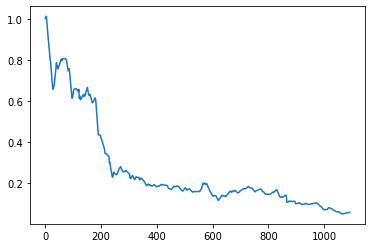

In [ ]:
cumulative_returns = np.cumprod(results + 1)

plt.plot(range(X_test_combined.shape[1]), cumulative_returns)
plt.show()

###for arima

In [ ]:

yhat2 = np.array(predictions_from_arima)

yhat2.shape

type(yhat2)
new_yhat2 = yhat2.astype("float64")

new_yhat2.shape
act_returns2 = np.exp(new_yhat2) - 1
act_returns2.shape

(58968,)

In [ ]:
yhat2 = act_returns2
results = np.zeros(X_test_combined.shape[1])
for i in range(X_test_combined.shape[1]): 
  #print(i)
  input_features = X_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], X_test_combined.shape[2])
  predicted_returns = yhat2[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1)
  actual_returns = y_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1)
  try:
    results[i] = wrapper(input_features, predicted_returns, actual_returns, rates['daily'][i-1092])
  except:
    results[i] = results[i-1]

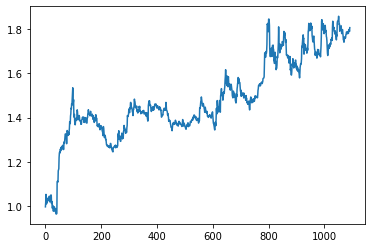

In [ ]:
cumulative_returns = np.cumprod(results + 1)
cumulative_returns = np.power(cumulative_returns, [-1]*1092)
plt.plot(range(X_test_combined.shape[1]), cumulative_returns)
plt.show()

In [ ]:
dict = {'arima_cim_prod': cumulative_returns}  
       
df = pd.DataFrame(dict) 
    
# saving the dataframe 
df.to_csv('arima_manuprig.csv') 